In [1]:
import numpy as np
import json
import os
import pycolmap
import shutil
from pyquaternion import Quaternion
from pathlib import Path

from hloc.triangulation import create_db_from_model
from hloc.utils.read_write_model import Camera, Image, Point3D, CAMERA_MODEL_NAMES
from hloc.utils.read_write_model import write_model, read_model
from hloc import extract_features, match_features, pairs_from_poses, pairs_from_exhaustive, triangulation, reconstruction
from hloc import visualization
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

In [2]:
from scipy.spatial.transform import Rotation
def convert_vec_to_matrix(vec_p, vec_q, mode='xyzw'):
	# Initialize a 4x4 identity matrix
	tf = np.eye(4)
	if mode == 'xyzw':
		# Set the rotation part of the transformation matrix using the quaternion
		tf[:3, :3] = Rotation.from_quat(vec_q).as_matrix()
		# Set the translation part of the transformation matrix
		tf[:3, 3] = vec_p
	elif mode == 'wxyz':
		# Set the rotation part of the transformation matrix using the quaternion
		tf[:3, :3] = Rotation.from_quat(np.roll(vec_q, -1)).as_matrix()
		# Set the translation part of the transformation matrix
		tf[:3, 3] = vec_p
	return tf
def convert_matrix_to_vec(tf_matrix, mode='xyzw'):
	if mode == 'xyzw':
		# Extract the translation vector from the matrix
		vec_p = tf_matrix[:3, 3]
		# Extract the rotation part of the matrix and convert it to a quaternion
		vec_q = Rotation.from_matrix(tf_matrix[:3, :3]).as_quat()
	if mode == 'wxyz':
		# Extract the translation vector from the matrix
		vec_p = tf_matrix[:3, 3]
		# Extract the rotation part of the matrix and convert it to a quaternion
		vec_q = np.roll(Rotation.from_matrix(tf_matrix[:3, :3]).as_quat(), 1)
	return vec_p, vec_q

15 mapping images
['seq1/frame_00000.jpg', 'seq1/frame_00001.jpg', 'seq1/frame_00002.jpg', 'seq1/frame_00003.jpg', 'seq1/frame_00004.jpg', 'seq1/frame_00005.jpg', 'seq1/frame_00006.jpg', 'seq1/frame_00007.jpg', 'seq1/frame_00008.jpg', 'seq1/frame_00009.jpg', 'seq1/frame_00010.jpg', 'seq1/frame_00011.jpg', 'seq1/frame_00012.jpg', 'seq1/frame_00013.jpg', 'seq1/frame_00014.jpg']
Writing the COLMAP model...


({0: Camera(id=0, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  1: Camera(id=1, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  2: Camera(id=2, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  3: Camera(id=3, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  4: Camera(id=4, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  5: Camera(id=5, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  6: Camera(id=6, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  7: Camera(id=7, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  8: Camera(id=8, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  9: Camera(id=9, model='PINHOLE', width=640, height=360, params

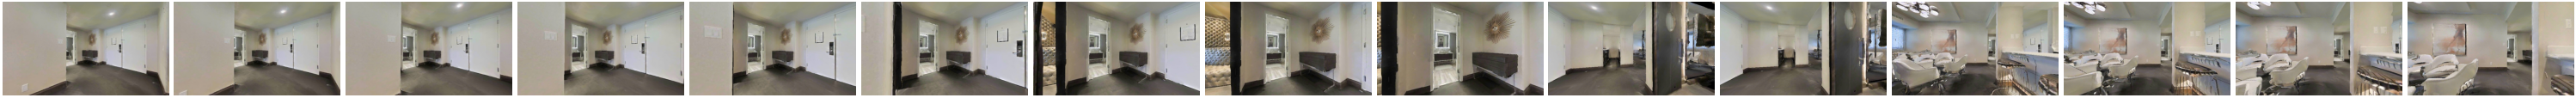

In [3]:
N_image = 15
query = 'seq0/frame_00000.jpg'
data_path = '/Rocket_ssd/dataset/data_litevloc/matterport3d/map_free_eval/test/s00000/'
images = Path(data_path)
outputs = Path("outputs_hlocp")
!rm -rf $outputs
sfm_pairs = outputs / "pairs-sfm.txt"
loc_pairs = outputs / "pairs-loc.txt"
sfm_dir = outputs / "sfm"
features = outputs / "features.h5"
matches = outputs / "matches.h5"

##### Load Iamges
references = [f'seq1/frame_{i:05}.jpg' for i in range(N_image)]
print(len(references), "mapping images")
print(references)
plot_images([read_image(images / r) for r in references], dpi=25)

##### Load Poses and Intrinsics
poses = {}
with (images / 'poses.txt').open('r') as f:
    for line in f.readlines():
        if '#' in line: continue
        line = line.strip().split(' ')
        img_name = line[0]
        qwxyz, txyz = np.array(list(map(float, line[1:5]))), np.array(list(map(float, line[5:])))
        # NOTE(gogojjh): colmap use world-to-camera transformation matrix where the camera is the reference frame
        # i.e., p_cam = T_c2w * p_world
        T_c2w = convert_vec_to_matrix(txyz, qwxyz, mode='wxyz')
        poses[img_name] = (qwxyz, txyz)

intrinsics = {}
with (images / 'intrinsics.txt').open('r') as f:
    for line in f.readlines():
        if '#' in line: continue
        line = line.strip().split(' ')
        img_name = line[0]
        fx, fy, cx, cy, width, height = float(line[1]), float(line[2]), float(line[3]), float(line[4]), float(line[5]), float(line[6])
        intrinsics[img_name] = (fx, fy, cx, cy, width, height)

##### Create Image Objects
colmap_images = {}
colmap_cameras = {}
for idx, ref_img in enumerate(references):
    qwxyz, txyz = poses[ref_img]
    intrinsic = intrinsics[ref_img]
    image = Image(
        id=idx,
        qvec=qwxyz,
        tvec=txyz,
        camera_id=idx,
        name=ref_img,
        xys=[],
        point3D_ids=[]
    )
    colmap_images[idx] = image
    
    fx, fy, cx, cy, width, height = intrinsic
    camera = Camera(
        id=idx, model='PINHOLE', 
        width=int(width), height=int(height), 
        params=[fx, fy, cx, cy]
    )
    colmap_cameras[idx] = camera

points3D = {}
print('Writing the COLMAP model...')
colmap_arkit = outputs / 'colmap_arkit'
colmap_arkit.mkdir(exist_ok=True, parents=True)
write_model(images=colmap_images, cameras=colmap_cameras, points3D=points3D, path=str(colmap_arkit), ext='.bin')

[2024/11/19 18:41:15 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


feature_conf:  {'output': 'feats-disk', 'model': {'name': 'disk', 'max_keypoints': 5000}, 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
matcher_conf:  {'output': 'matches-disk-lightglue', 'model': {'name': 'lightglue', 'features': 'disk'}}


/home/jjiao/anaconda3/envs/pose_estimation/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
100%|██████████| 15/15 [00:00<00:00, 37.96it/s]
[2024/11/19 18:41:15 hloc INFO] Finished exporting features.
[2024/11/19 18:41:15 hloc INFO] Reading the COLMAP model...
[2024/11/19 18:41:15 hloc INFO] Obtaining pairwise distances between 15 images...
[2024/11/19 18:41:15 hloc INFO] Found 102 pairs.
[2024/11/19 18:41:15 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
/home/jjiao/anaconda3/envs/pose_estimation/lib/python3.8/site-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.

Successful trianglation: 13 / 15
Number of 3D Points:  2858
Image(image_id=12, camera_id=12, name="seq1/frame_00012.jpg", triangulated=1044/2003)
Image(image_id=11, camera_id=11, name="seq1/frame_00011.jpg", triangulated=868/2109)
Image(image_id=10, camera_id=10, name="seq1/frame_00010.jpg", triangulated=0/1899)
Image(image_id=9, camera_id=9, name="seq1/frame_00009.jpg", triangulated=0/1840)
Image(image_id=8, camera_id=8, name="seq1/frame_00008.jpg", triangulated=1036/1684)
Image(image_id=7, camera_id=7, name="seq1/frame_00007.jpg", triangulated=996/1744)
Image(image_id=6, camera_id=6, name="seq1/frame_00006.jpg", triangulated=1127/1710)
Image(image_id=5, camera_id=5, name="seq1/frame_00005.jpg", triangulated=1143/1607)
Image(image_id=4, camera_id=4, name="seq1/frame_00004.jpg", triangulated=1103/1423)
Image(image_id=3, camera_id=3, name="seq1/frame_00003.jpg", triangulated=1095/1400)
Image(image_id=2, camera_id=2, name="seq1/frame_00002.jpg", triangulated=1104/1358)
Image(image_id=1, 

Reconstruction:
	num_reg_images = 15
	num_cameras = 15
	num_points3D = 2858
	num_observations = 13236
	mean_track_length = 4.63121
	mean_observations_per_image = 882.4
	mean_reprojection_error = 0.896061


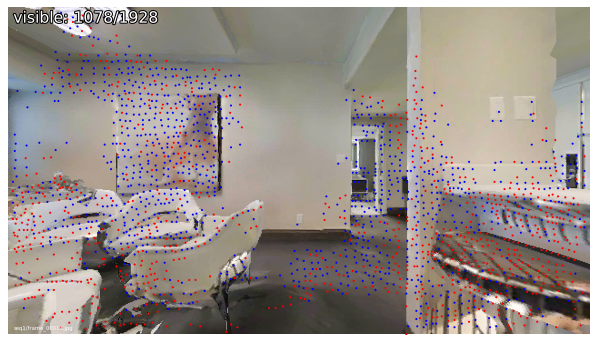

In [4]:
feature_conf = extract_features.confs['disk']
# feature_conf['model']['max_keypoints'] = 2048
matcher_conf = match_features.confs['disk+lightglue']
print('feature_conf: ', feature_conf)
print('matcher_conf: ', matcher_conf)

##### Extract Features 
colmap_sparse = outputs / 'colmap_sparse'
colmap_sparse.mkdir(exist_ok=True, parents=True)

extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_poses.main(colmap_arkit, sfm_pairs, len(references))
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)
model = triangulation.main(colmap_sparse, colmap_arkit, images, sfm_pairs, features, matches)

if model is not None or len(model.points3D) > 500:
    visualization.visualize_sfm_2d(model, images, color_by="visibility", n=1)
    cnt = sum(1 for image in model.images.values() if image.num_points3D > 500)
    print('Successful trianglation:', cnt, '/', len(model.images))
    print('Number of 3D Points: ', len(model.points3D))
    for image in model.images.values(): print(image)

    fig = viz_3d.init_figure()
    viz_3d.plot_reconstruction(fig, model, color="rgba(255,0,0,0.5)", name="mapping", points_rgb=True)
    fig.show()
print(model.summary())

[2024/11/19 18:41:17 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
100%|██████████| 1/1 [00:00<00:00, 19.87it/s]
[2024/11/19 18:41:17 hloc INFO] Finished exporting features.
[2024/11/19 18:41:17 hloc INFO] Found 15 pairs.
[2024/11/19 18:41:17 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
100%|██████████| 15/15 [00:00<00:00, 69.76it/s]
[2024/11/19 18:41:18 hloc INFO] Finished exporting matches.


found 718/1356 inlier correspondences.


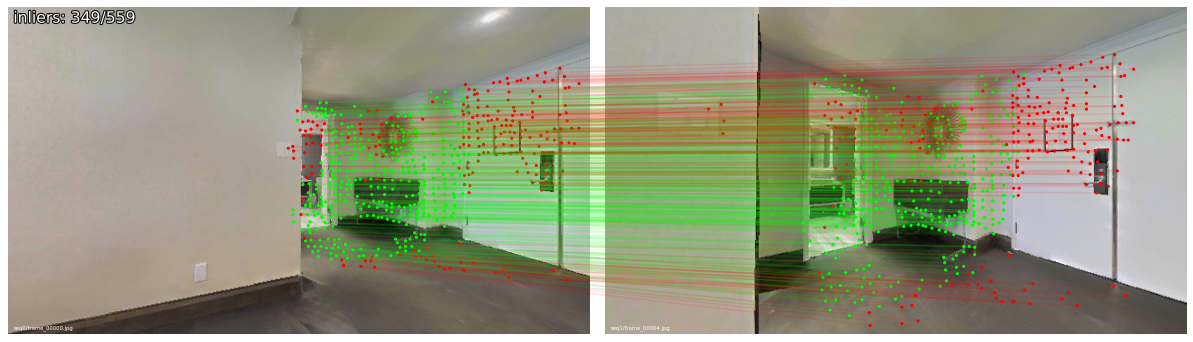

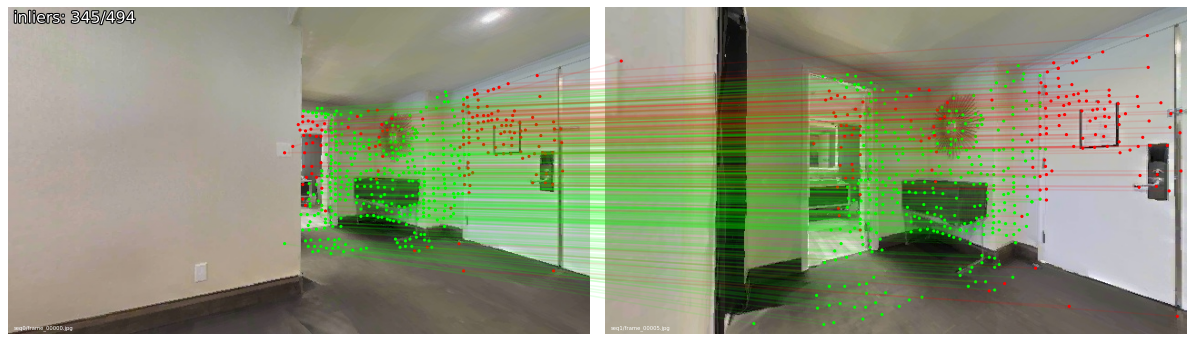

In [5]:
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True)

import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r).image_id for r in references if model.find_image_with_name(r) is not None]
conf = {
    "estimation": {"ransac": {"max_error": 12}},
    "refinement": {"refine_focal_length": True, "refine_extra_params": True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

pose = pycolmap.Image(cam_from_world=ret["cam_from_world"])
viz_3d.plot_camera_colmap(fig, pose, camera, color="rgba(0,255,0,0.5)", name=query, fill=True)
viz_3d.plot_camera_colmap(fig, pycolmap.Image(cam_from_world=pycolmap.Rigid3d()), camera, color="rgba(0,0,255,0.5)", name='world', fill=True)
# visualize 2D-3D correspodences
inl_3d = np.array(
    [model.points3D[pid].xyz for pid in np.array(log["points3D_ids"])[ret["inliers"]]]
)
viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name=query)
fig.show()

In [7]:
for image_id, image in model.images.items():
    print(image_id, image.name, image.cam_from_world.translation)
print(query, ret['cam_from_world'].translation)
print('query camera: ', camera)
print(camera.params[0])

12 seq1/frame_00012.jpg [0.23516134 0.         1.50585603]
11 seq1/frame_00011.jpg [0.23516184 0.         1.75585934]
10 seq1/frame_00010.jpg [0.67154093 0.         2.78364874]
9 seq1/frame_00009.jpg [0.50913565 0.         2.8751633 ]
8 seq1/frame_00008.jpg [-3.18581367e-01  3.36890000e-05 -1.79898608e+00]
7 seq1/frame_00007.jpg [-0.32561201  0.         -1.54757007]
6 seq1/frame_00006.jpg [-0.14380333  0.         -1.35219871]
5 seq1/frame_00005.jpg [-0.11954075  0.         -1.10531253]
4 seq1/frame_00004.jpg [-0.08435386  0.         -0.86193531]
3 seq1/frame_00003.jpg [ 5.56412000e-04  0.00000000e+00 -6.33225535e-01]
2 seq1/frame_00002.jpg [ 0.00056117  0.         -0.38822462]
1 seq1/frame_00001.jpg [ 5.59829000e-04  8.32000000e-07 -1.43477896e-01]
0 seq1/frame_00000.jpg [ 0.000329    0.         -0.01149348]
13 seq1/frame_00013.jpg [ 2.35183289e-01 -1.00020000e-05  1.25586060e+00]
14 seq1/frame_00014.jpg [ 2.35176843e-01 -7.48700000e-06  1.00085533e+00]
seq0/frame_00000.jpg [0.01370859